# Visão Computacional e Deep Learning para Sensoriamento Remoto com Python


# Capítulo 16 - Segmentação de Estradas e Ruas usando o Pytorch

Vamos iniciar conectando o Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Agora importaremos algumas funções e bibliotecas:

In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

Vamos agora instaar e importar a biblioteca segmentation models pytorch

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics as smp_metrics

Aqui definimos o caminho de onde estão as imagens e mascaras de treinameno e de teste:

In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/Datasets/Road extraction dataset/train"
TEST_DIR = "/content/drive/MyDrive/Datasets/Road extraction dataset/test"

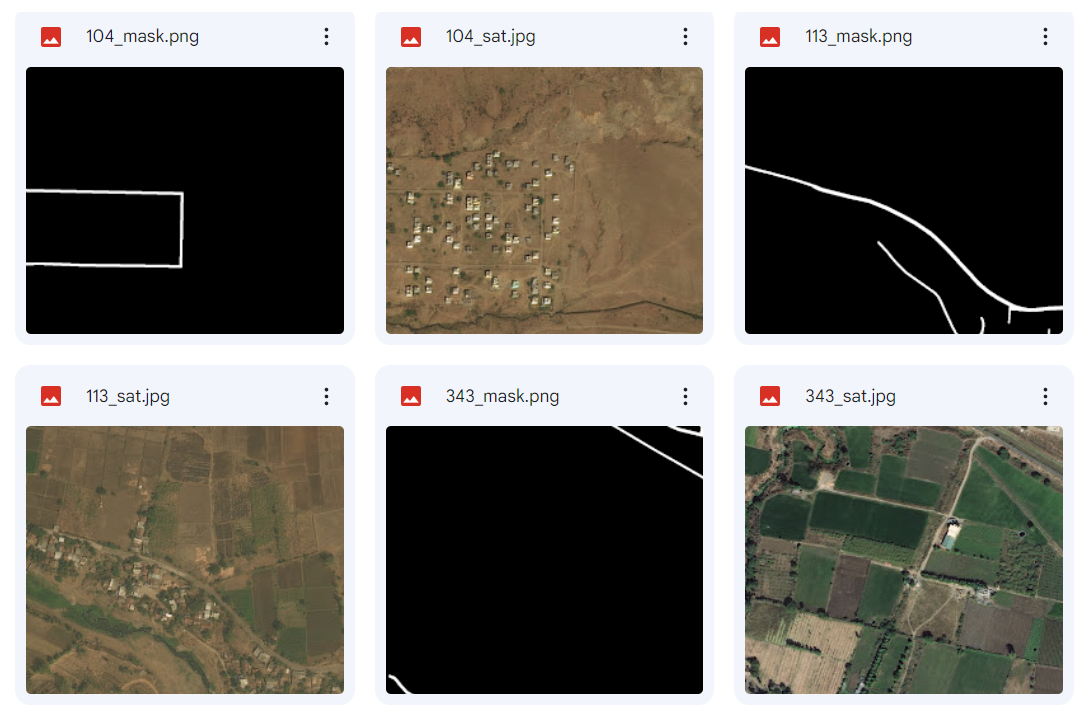

Definimos as listas de imagens:

In [ ]:
img_list_train = [ f for f in os.listdir(TRAIN_DIR) if f.split('.')[0].endswith('sat')]
img_list_test = [ f for f in os.listdir(TEST_DIR) if f.split('.')[0].endswith('sat')]

Separamos a lista de imagens de treinamento em 70% para treinar e 30% para validar o algoritmo.

In [ ]:
img_list_train = [ f for f in os.listdir(TRAIN_DIR) if f.split('.')[0].endswith('sat')]
im_list = random.sample(img_list_train, len(img_list_train))
train_idx = round(len(im_list) * 0.7)
test_idx  = train_idx + round(len(im_list) * 0.3)

Assim criamos as listas de imagens e máscaras de teste e validação:

In [ ]:
img_list_train = im_list[0:train_idx]
img_list_val = im_list[train_idx:test_idx]

In [ ]:
mask_list_train = []
for i in img_list_train:
  id = i.split('_')[0]
  mask_name = id + '_mask.png'
  mask_list_train.append(mask_name)

In [ ]:
mask_list_val = []
for i in img_list_val:
  id = i.split('_')[0]
  mask_name = id + '_mask.png'
  mask_list_val.append(mask_name)

Vamos então criar nosso diretóro raiz e dentro dele criar pastas para armazenar as imagens e máscaras de train e val.

In [ ]:
!mkdir data
%cd data

/content/data


In [ ]:
!mkdir train
!mkdir train_labels
!mkdir val
!mkdir val_labels
!mkdir test
!mkdir test_labels
%cd ..

/content


Assim, podemos fazer uma função para criar uma cópia da imagem do Drive e salvá-la em nosso diretório do /content:

In [ ]:
OUTPUT_PATH = '/content/data/train'
for image_file in img_list_train:
  shutil.copyfile(
              os.path.join(TRAIN_DIR,image_file),
              os.path.join(OUTPUT_PATH,image_file)
          )

In [ ]:
OUTPUT_PATH = '/content/data/train_labels'
for image_file in mask_list_train:
  shutil.copyfile(
              os.path.join(TRAIN_DIR,image_file),
              os.path.join(OUTPUT_PATH,image_file)
          )

In [ ]:
OUTPUT_PATH = '/content/data/val'
for image_file in img_list_val:
  shutil.copyfile(
              os.path.join(TRAIN_DIR,image_file),
              os.path.join(OUTPUT_PATH,image_file)
          )

In [ ]:
OUTPUT_PATH = '/content/data/val_labels'
for image_file in mask_list_val:
  shutil.copyfile(
              os.path.join(TRAIN_DIR,image_file),
              os.path.join(OUTPUT_PATH,image_file)
          )

In [ ]:
OUTPUT_PATH = '/content/data/test'
for image_file in img_list_test:
  shutil.copyfile(
              os.path.join(TEST_DIR,image_file),
              os.path.join(OUTPUT_PATH,image_file)
          )

A proxima etapa é definir so caminhos de onde estão os dados:

In [ ]:
DATA_DIR = '/content/data'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')

Definimos as classes:

In [ ]:
class_names =  ['background', 'road']
class_rgb_values = [[0, 0, 0], [255, 255, 255]]

A partir das classes que temos em nosso dataset definimos quais valores de pixels são de cada classe.

In [ ]:
select_classes = ['background', 'road']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


Criamos algumas função de auxílio, para visualizar os dados, e conversão da mascara para o formato one-hot-encode.

In [ ]:
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

Assim, podemos definir nosso dataset como uma classe com funções para importar as imagens e máscaras e alimentar o modelo.

In [ ]:
class RoadsDataset(torch.utils.data.Dataset):

    """Massachusetts Roads Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

Instânciamos a classe do nosso dataset e visualizamos um exemplo de imagem e máscara:

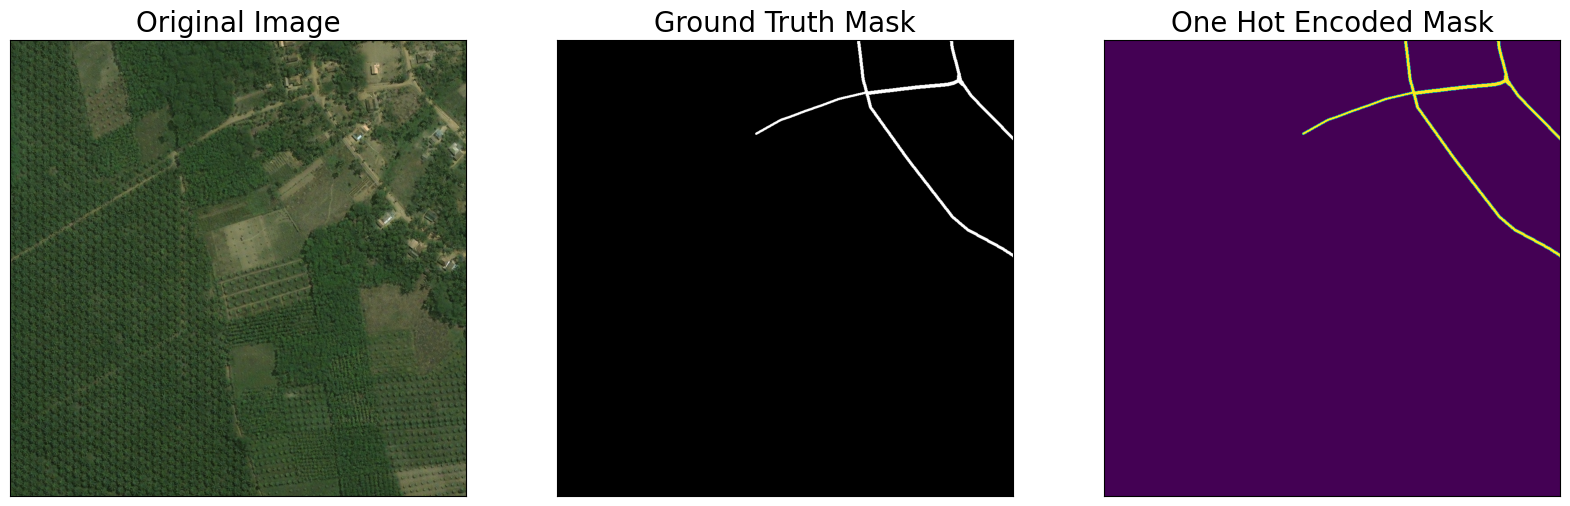

In [ ]:
dataset = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)

image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

Criamos uma função para aumento de dados:

In [ ]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

Também podemos visualizar as imagens geradas pelo aumento de dados.

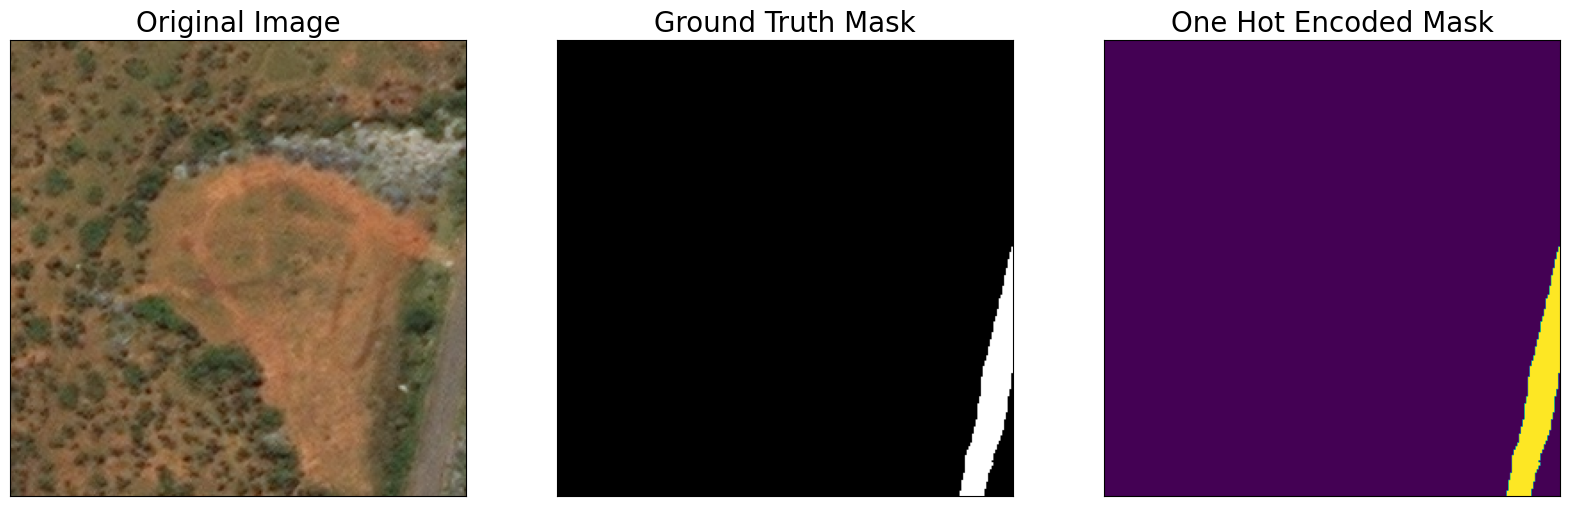

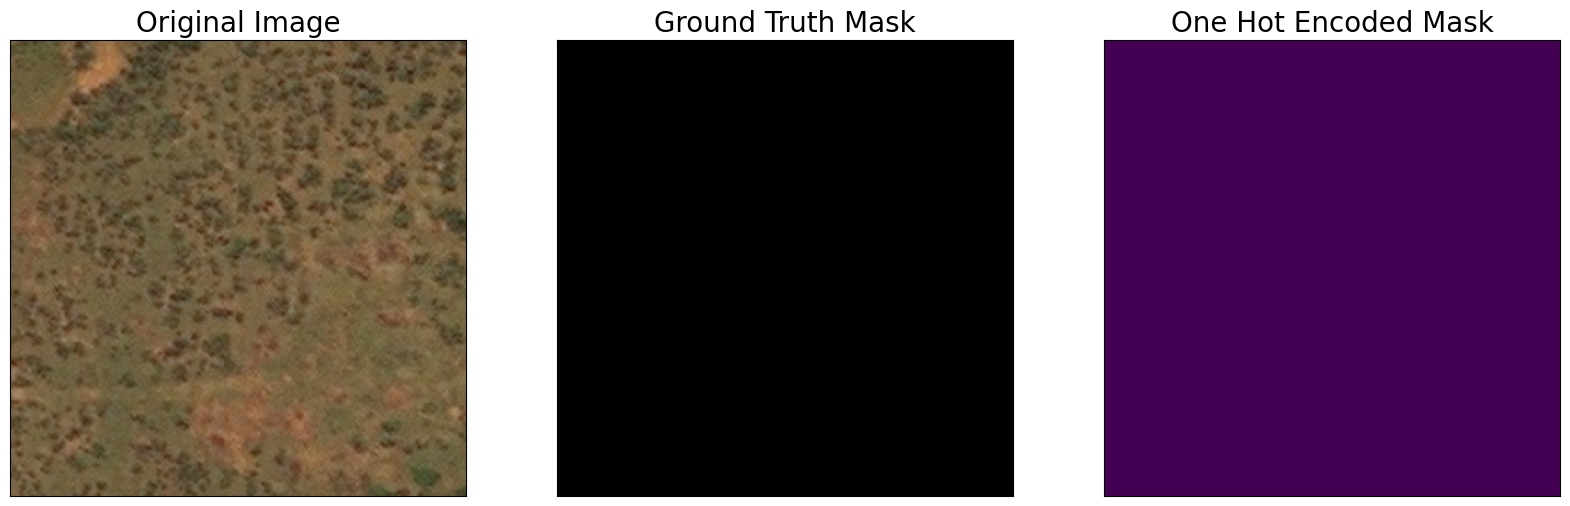

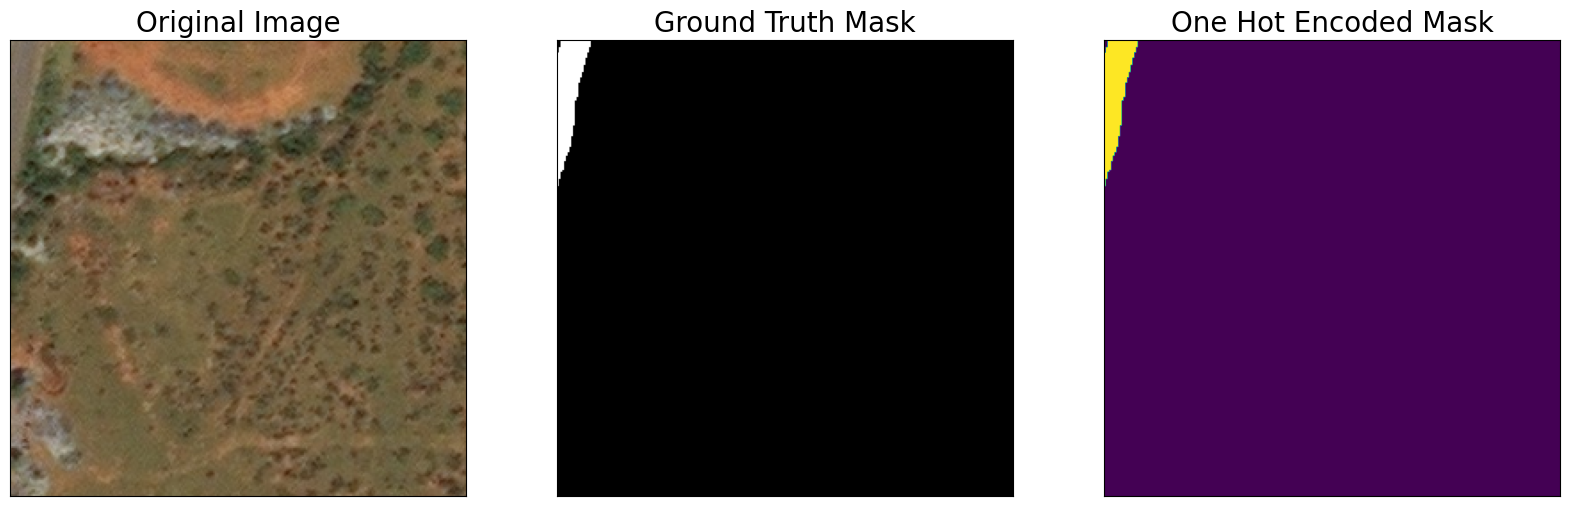

In [ ]:
augmented_dataset = RoadsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

Vamos importar nosso modelo da U-NET com a resnet50 de backbone e os pesos da imagenet.

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Instânciamos os datasets de treinamento e validação.

In [ ]:
train_dataset = RoadsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

Podemos então definir alguns parâmetros como quantidade de épocas, otimizador, learning rate, onde será salvo o arquivo de pesos, etc.

In [ ]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.losses.DiceLoss('binary')
loss.__name__ = 'Dice_loss'

# define metrics
metrics = [
    smp_metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
    model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)

Intânciamos o treinamento e a validação.

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

E enfim podemos iniciar o treinamento:

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 1868/1868 [08:06<00:00,  3.84it/s, Dice_loss - 0.6299, iou_score - 0.4249]
Model saved!

Epoch: 1
valid: 100%|██████████| 1868/1868 [08:06<00:00,  3.84it/s, Dice_loss - 0.6207, iou_score - 0.4265]
Model saved!

Epoch: 2
valid: 100%|██████████| 1868/1868 [08:05<00:00,  3.85it/s, Dice_loss - 0.6181, iou_score - 0.4275]
Model saved!

Epoch: 3
valid: 100%|██████████| 1868/1868 [08:06<00:00,  3.84it/s, Dice_loss - 0.6169, iou_score - 0.4284]
Model saved!

Epoch: 4
valid: 100%|██████████| 1868/1868 [08:06<00:00,  3.84it/s, Dice_loss - 0.6162, iou_score - 0.4289]
Model saved!
CPU times: user 42min, sys: 3min 55s, total: 45min 56s
Wall time: 55min 59s


Após o fim do treinamento salvamos os pesos treinados em um aquivo. Agora para usá-los nas predições, realizamos o carregamento destes pesos.

In [ ]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
    best_model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


Agora, carregamos os dados de validação e visualizamos:

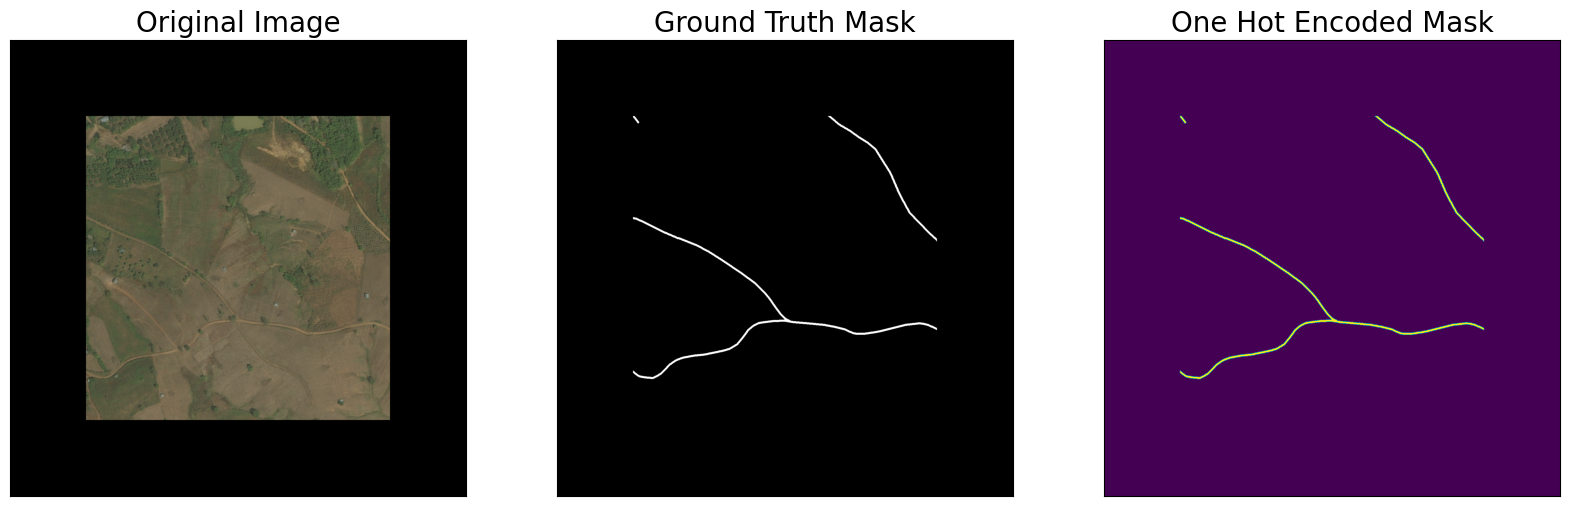

In [ ]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = RoadsDataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = RoadsDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

Criamos uma função para recortar a parte central da imagem:

In [ ]:
def crop_image(image, target_image_dims=[1500,1500,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    if padding<0:
        return image

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

Criamos uma pasta para receber os arquivos predictos:

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
range(len(test_dataset))

range(0, 1868)

Por fim para cada imagem do dataset de validação, recortamos a imagem, aplicamos o modelo e obtemos a predição. Então plotamos a imagem, a máscara anotada e a máscara predicta para compararmos os resultados:

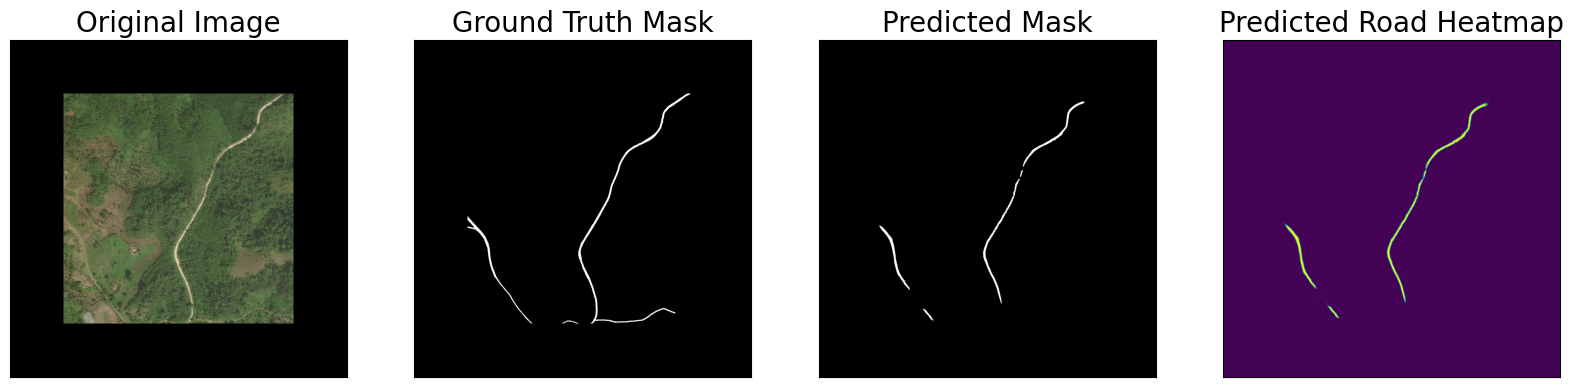

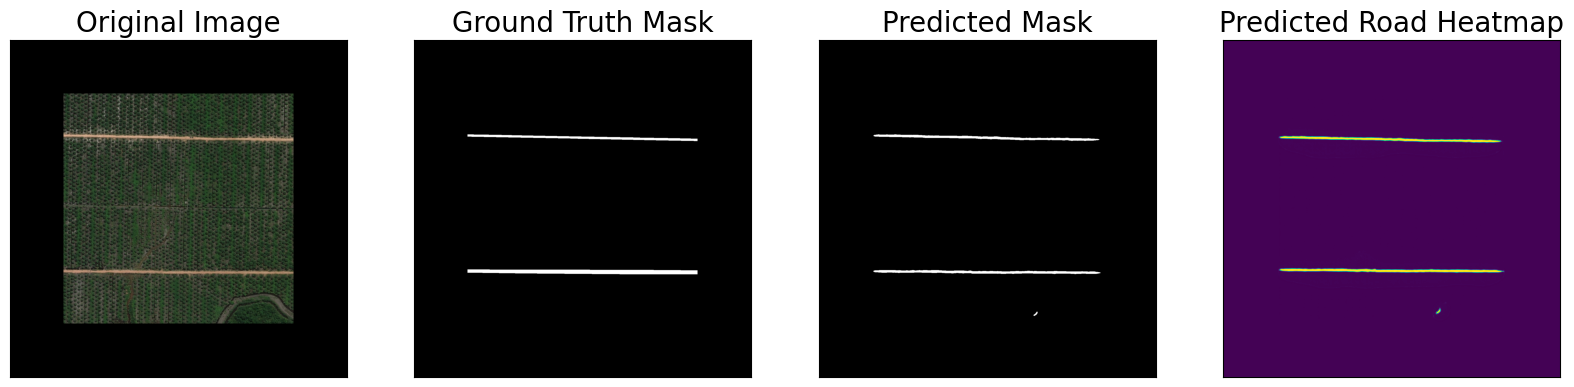

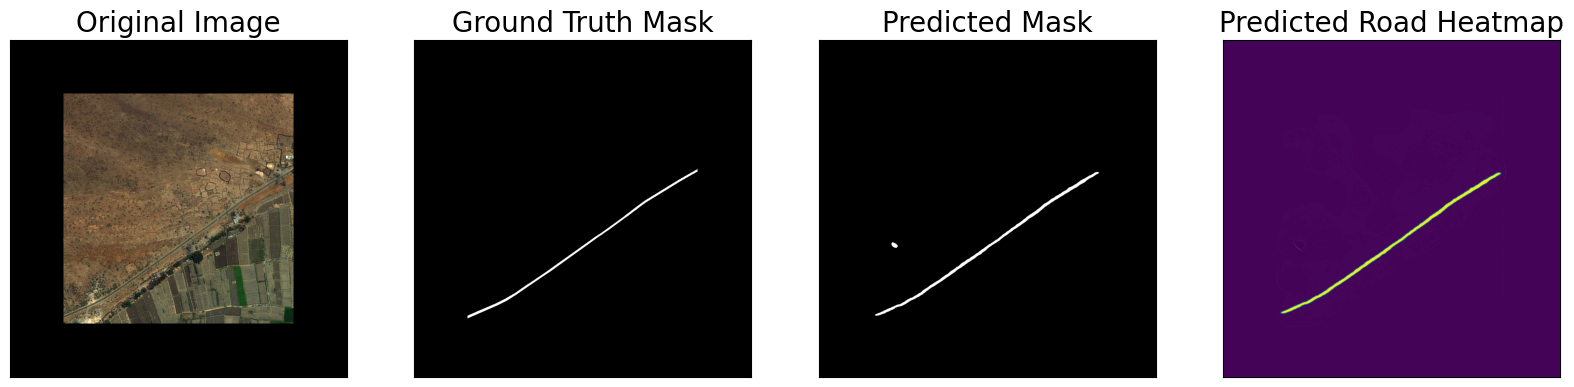

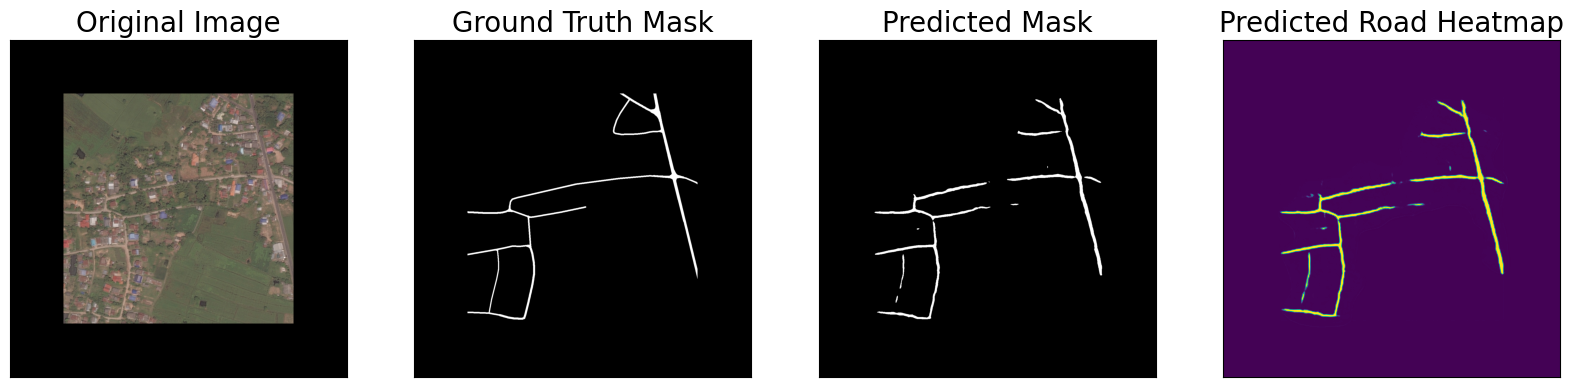

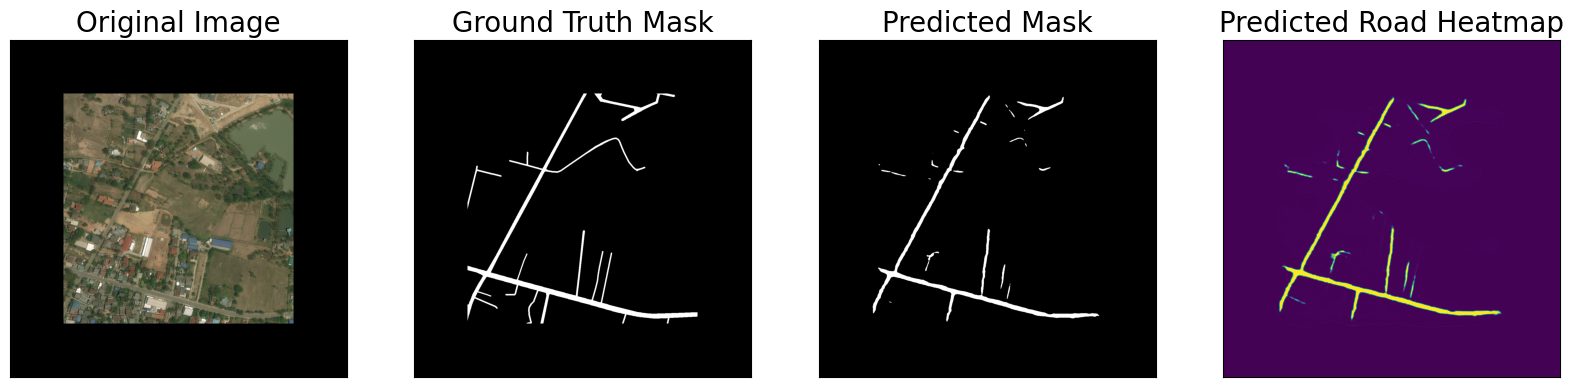

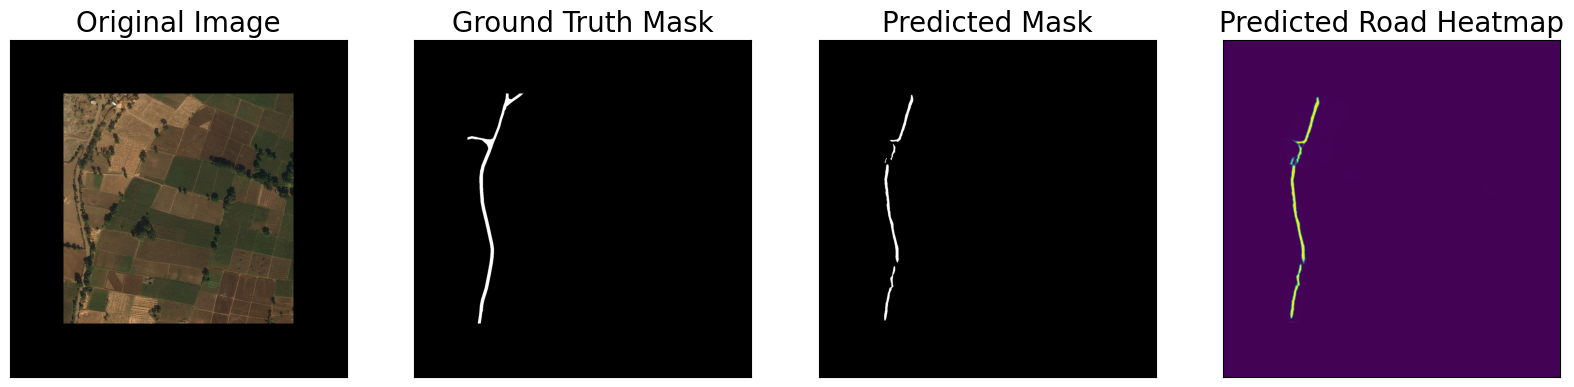

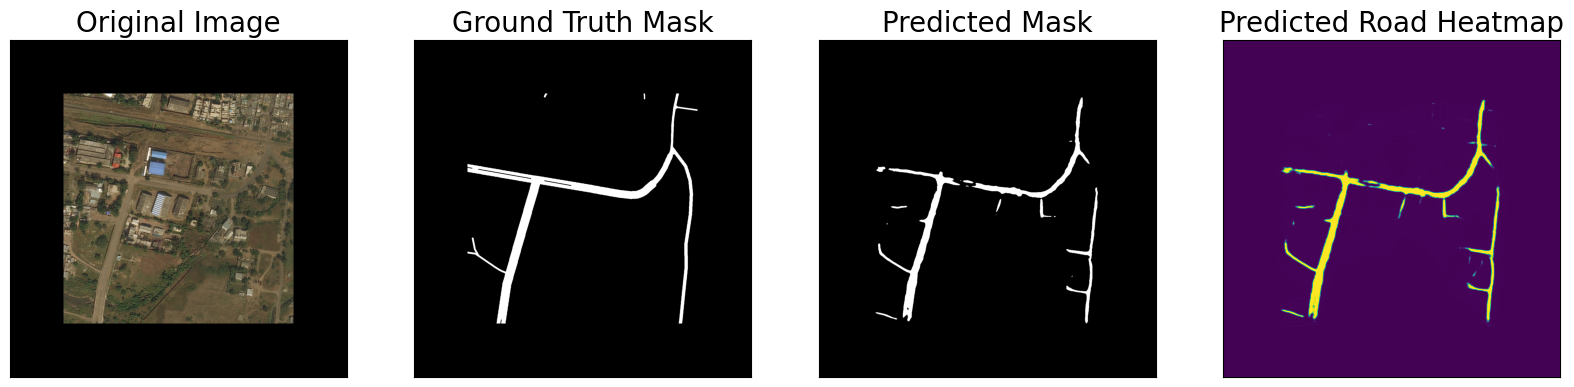

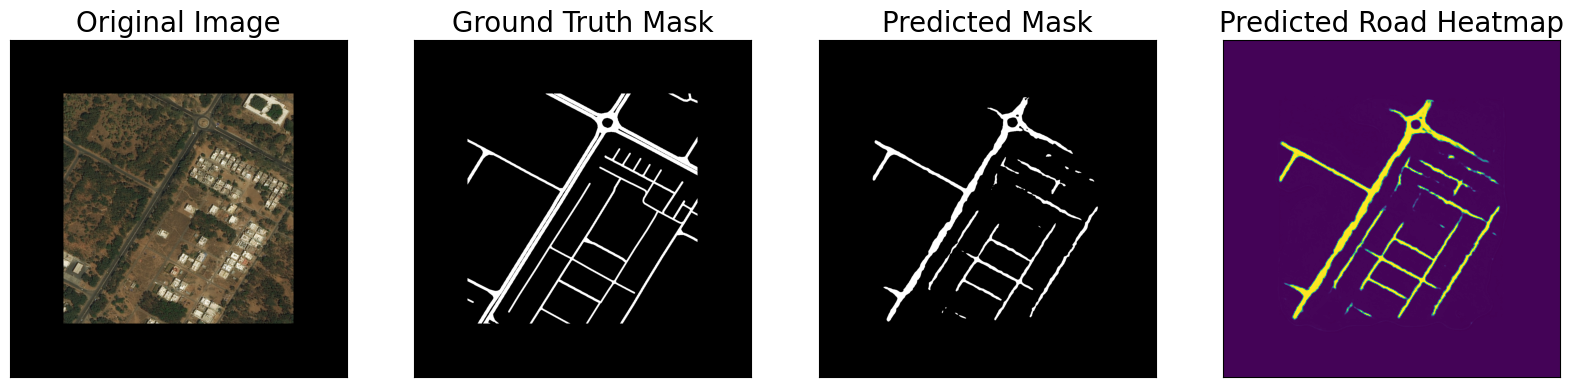

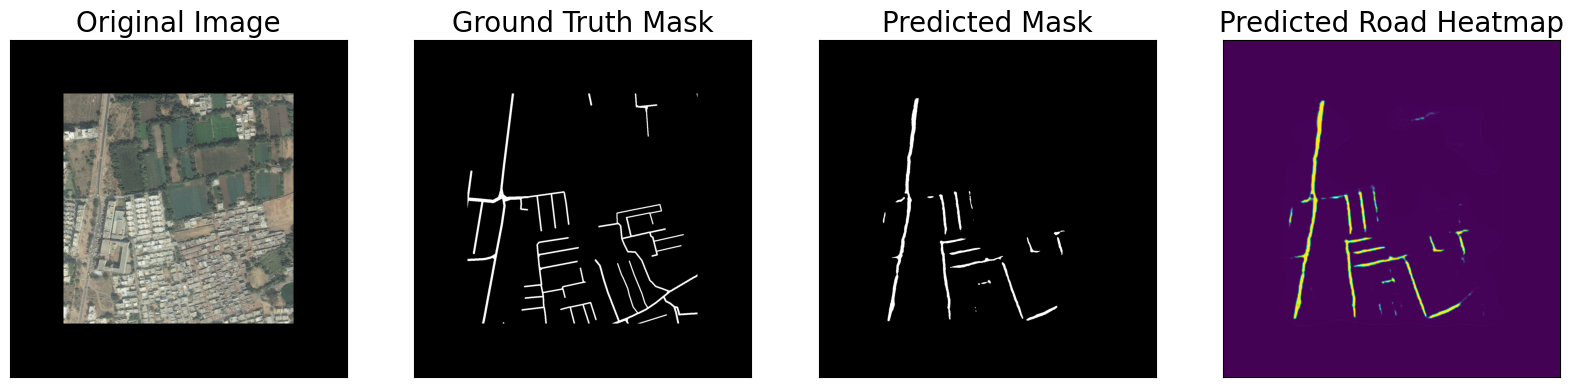

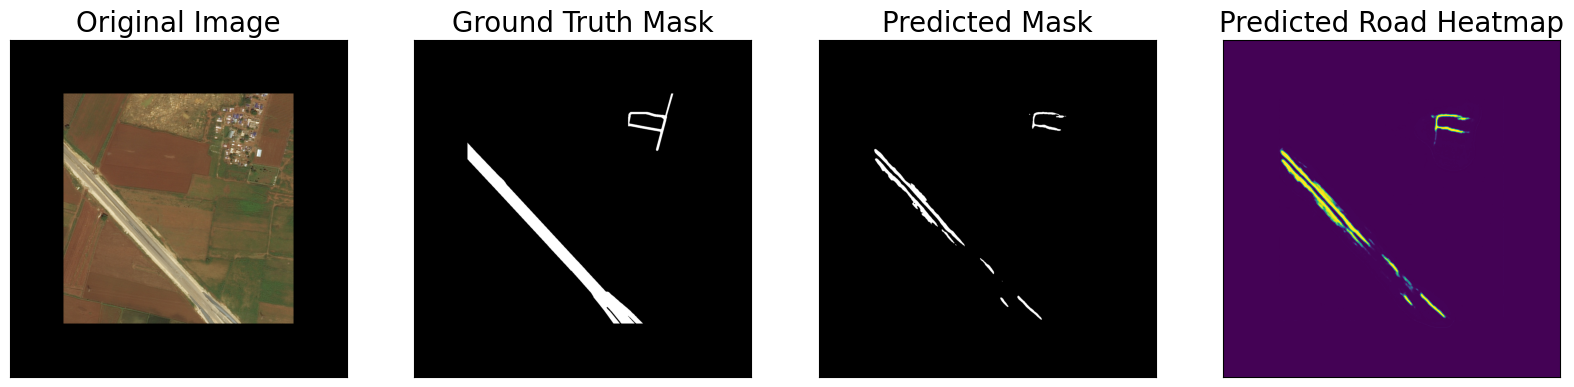

In [ ]:
for idx in range(10):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to road
    pred_road_heatmap = pred_mask[:,:,select_classes.index('road')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_road_heatmap = pred_road_heatmap
    )

Também podemos obter algumas métricas a partir do modelo:

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['Dice_loss']:.4f}")

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2         3         4
Dice_loss  0.397153  0.366067  0.357746  0.354551  0.352911
iou_score  0.827065  0.934210  0.938702  0.941689  0.943787

Podemos obter um gráfico de IoU por época e Dice Loss por época:

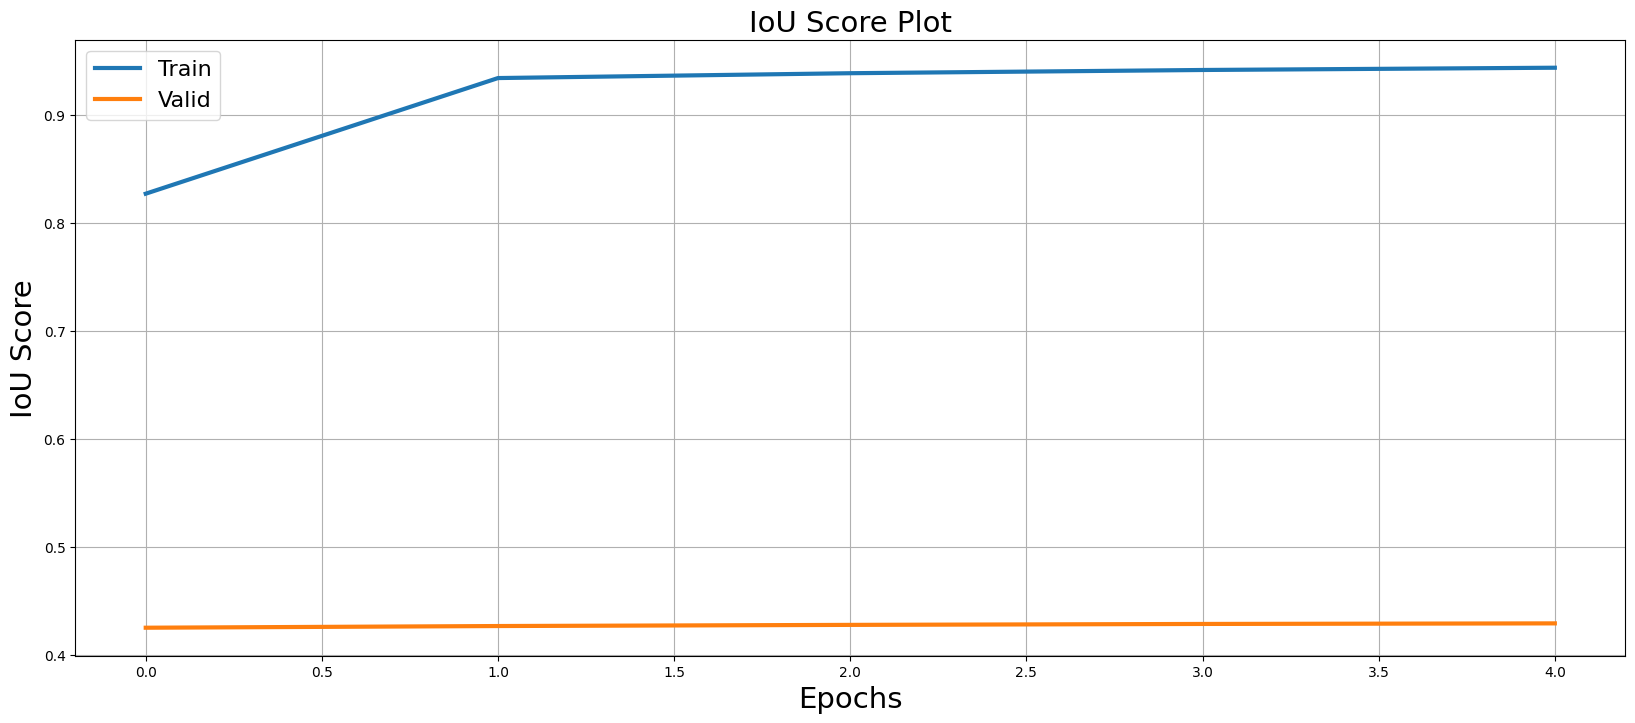

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

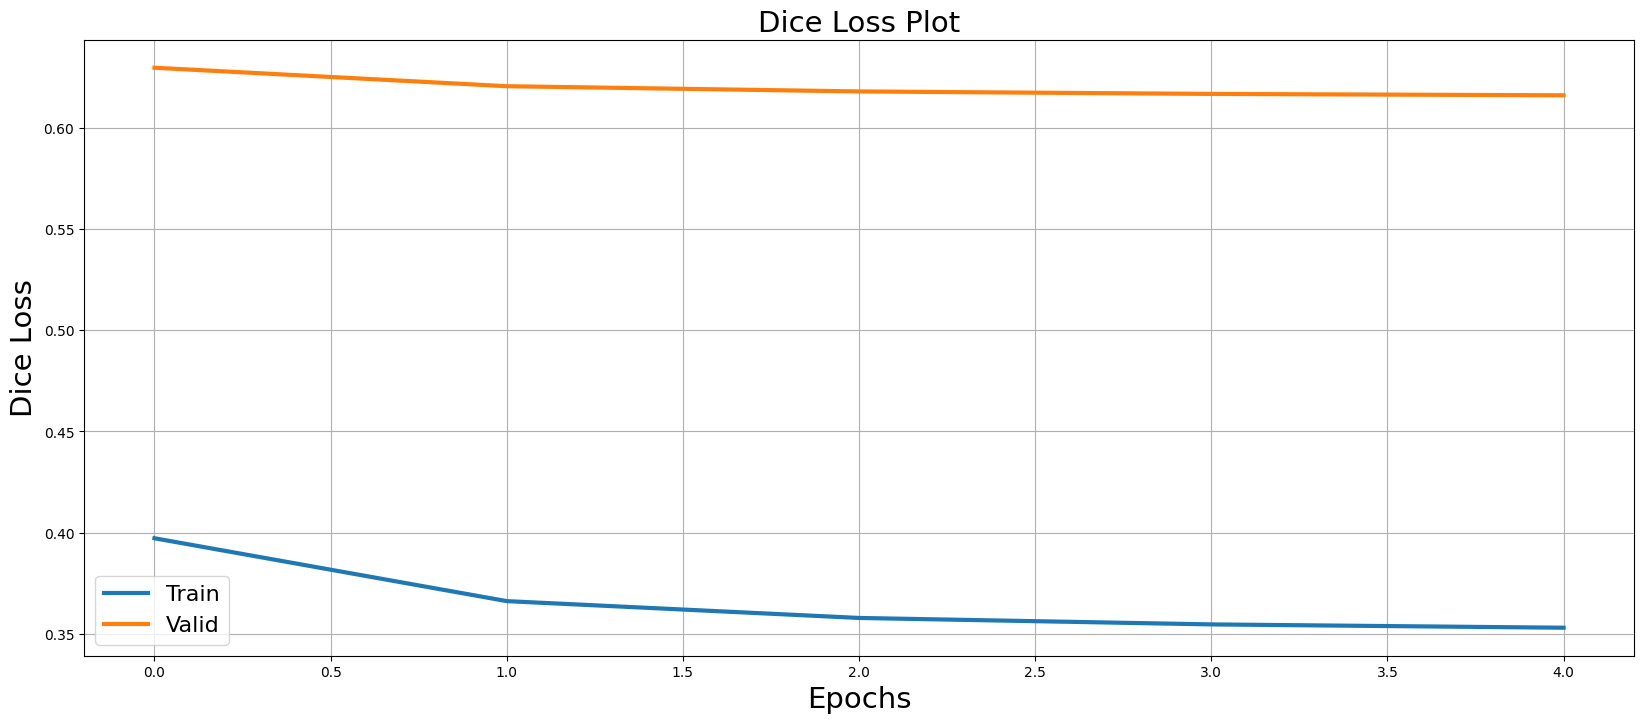

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.Dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.Dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()